# 0 Neural Networks from Scratch | Mathematics and Python Code
Taken from the Independent Code Channel
[NeuralNetworks from Scratch](https://www.youtube.com/watch?v=pauPCy_s0Ok)

This video series recreates several neural networks and codes them out using only python and numpy in Tensorflow/Keras similiar style. From a PyTorch perspective, it creates a nn.Module base class (without the automation) and reproduces Activation functions, loss functions along with back-propagation and gradient descent.

The mathematics are fully explained including the complicated gradient descent which is taking partial derivitives of the loss with respect to each input parameter. 
For example, the the derivitive of loss E wrt the output (y) is  dE/dY.  The partial derivitive would be for the weights dE/dW, the bias dE/dB and X (dE/dX).
Note: that the partial derivitive dE/dX is actually the dE/dY of the previous layer which allows us to pass this value back to the feeding layer to update its learnable parameters.

In [13]:
import sys
print(sys.executable)

C:\Users\Ronald\anaconda3\envs\pytorch_env1\python.exe


## 0.1 PyTorch <-> nomenclature
Since the author is writing code to implement Tensorflow like objects, I want to be sure I use the naming conventions correctly when switching back to Pytorch.
1. What I call a Model, the author is calling it network  so this class definition:
   
   `network = [
   
        Dense(2,5),   # pytorch Linear Layer
   
        Tanh(),       # asymptotic horizontal tangent function
   
        Dense(5,10).
   
        Tanh()......

   ]`
   
   Where each of these `Layers` could be defined  as such
   
   `class MyCustomLayer(Layer):
   
       def forward(...):
   
           pass
   
       def backward(...):
   
           pass`
   
   
   This concept of the backward function is somewhat different (or hidden in Pytorch whereas the Loss function and the optimizer sort of did this. In any case that is the back-propagation.
   For every parameter that is in a module that is defined with requires_grad=True is keeping track of the values during the forward pass and which parameter to update during the back-propagation

## 1. Implementation

### 1.1 Design a modular system that is easy to use and easily extensible

Machine learning steps
1. Feed inout.  Data flows forward from layer to layer
2. Calculate the loss i.e E = (1/2)(y'- y)^2  (r mean squared error?)
3. Adjust parameters using gradient descent
       w <- w - @(pE/pW) # partial derivitive E wrt W
4. Start again

           ____________
       X-->|  Layer   | ---> Y
       <---|    W     | <---   
     pE/pX |----------|    pE/pY              
                |
              pE/pW


Using the chain rule: 

**pE/pW = pE/pY pY/pW**  pe/py is given as the loss, the pY/pw is specific to the mathematical function defined in the forward function. The layer itself can calculate this

**pE/pX = pE/pY pY/pX**  Again pE/pY is the loss. pE/pX IS the pE/pY for the previous layer


In [14]:
import numpy as np
import matplotlib.pyplot as plt

### 1.2 Create the base layer - a simple base class like nn.Module

In [15]:
class Layer:
    def __init__(self):
        self.input = None
        delf.output = None
#
    def forward(self,input):
        # TODO: returns output Y
        pass
#
    def backward(self, output_gradient, learning_rate):
        """
        params: output_gradient - partial derived loss wrt this layers output
                learning_rate - some constant applied to the output_gradient to adjust the weights
        returns: input_gradient  pE/pX  (which in turn becomes the pE/pY of the previous layer
         *optionaly passing in and returning an optimizer that encapsulates the gradient descent
        """
        # TODO update parameters and return input gradient (pE/pX)
        pass

### 1.3 Create the Dense layer - nn.Linear in pytorch

The dense layer - or fully connected layer

Connects a set of `i` input neurons to a set of `j` output neurons
Every input neuron has is connected to each and everyneuron in the output layer.
The weights are actually a partial description of the connection rather than the neuron itself.
This weight is depicted as W sub j sub i to designate the connection between input neuron i and output neuron j.

The inputs are designated as x1, x2, x3....xi

The outputs are y1,y2,y3...yj

where:

Yj is the sum of all input weight products from layer i

y1 = X1W11 + X2W12+X3W13 + .... + xiW1i + B1

y2 = X1W21 + X2W22 .... etc...

.

.

yj = X1Wj1 + X2Wj2 +...+XiWji + Bj


This can better be expressed as:

"|y1|....|W11 W12 ...W1i| |x1|...|b1|"

"|y2|....|W21 W22 ...W2i| |x2|...|b2|"

"|: |.=..| :.. :. \ ..: | | :| + |: |"

"|: |....| :.. :.. \ .: | | :|...|: |"

"|yj|....|Wj1 Wj2 ...Wji| |xi|...|bj|"

* j * 1        X * i       i * 1  j * 1

This then turns to a simple equation:

* Y = W ° X + B    where ° is the symbol of this sum of product, matrix DOT function

 

In [16]:
# from layer import Layer     # assume class is defined in its own package
import numpy as np
#
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
#
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.inputs) + self.bias
#
    def backward(self, output_gradient, learning_rate):
        # TODO update parameters and return input gradient
        pass

# see video referenced above for full explanation
pE/pY  passed in through output_gradient calculated by the loss function
        it has the same dimensions as  the output
        We will designate this as L where Lj is the jth element

* pE/pW = L ° Xt # transformed input matrix

pE/pB1 = (L1)(pY1/pB1) + ... + (Lj)(pYj/pB1) 
     since B1 only shows up in the Y1 = (above)all others are zero so..

* pE/pB = pE/pY or L

pE/pX1 (L1)(pY1/pX1) + ... + (Lj)(pYj/pB1)   
Since the terms for X1 shows up in every equation all weights are factored in so

pE/pX = L1(W1i) + L2(W2i) + .... + Lj(Wji) 
When we plug in the values from the above equation we see that the weight matrix is transposed so...

+ pE/pX = Wt ° L  Wt is the transposed weight matrix

We now have the equations to implement the backward function


In [17]:
# from layer import Layer     # assume class is defined in its own package
import numpy as np
#
class Dense(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
#
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.inputs) + self.bias
#
    def backward(self, output_gradient, learning_rate):
        weights_gradients = np.dot(output_gradient, self.input.T) # loss dot transpose(X)
        self.weights -= learning_rate * weights_gradients
        self.bias -= learning_rate * output_gradient  # just the loss itself
        return np.dot(self.weights.T, output_gradient) # transpose weights dot loss
    

### 1.4 Create the Activation layer base class

The activation layer is simply just another layer with a single function
It takes the input size and outputs a matrix of the same size
The forward function is simle y = F(x)
The backward function should simply return pE/pX since it has no paramters of its own

In [18]:
from layer import Layer
#
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        super().__init__()
        self.activation = activation
        self.activation_prime = activation_prime
#
    def forward(self, input):
        self.input = input
        return self.activation(self.input)
#
    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

the activation function is defined as y = f(x)

To calculate the output gradient given the loss pE/dY, we just do element-wise multiplication with the derived function activation_prime
pE/pX = L * f'(X)  this function is passed in as constructor parameter

### 1.5 Implement the Activation and loss functions

* We can create the hyperbolc tanget function and its derivitive

In [19]:
from activation import Activation
import numpy as np
#
class Tanh(Activation):
    def __init__(self):
        tanh = lambda x: np.tanh(x)
        tanh_prime = lambda x: 1-np.tanh(x)** 2
        super().__init__(tanh, tanh_prime)
    

* now we need a loss function

L1Loss im pytrch is MAE (Mean Absolute Error)
We will use the mean squared error  MSE ( I think in Pytorch this is L1Loss)
The function is defined as Err = (1/n) Epsilon((y_pred - y)**2)  of simply sum of all delta Y's squared

As we explained earlier Each layer og its pE/pY or loss, by receiving the pE_pX from the following layer.  So we now have to give the finel layer this value and here is where we calculate it. But we need to pass pE/pY and not the actual calculation above.  we need loss_prime  which is:

pE/pY = (2/n)(-delta Y)

In [20]:
# we could create a loss base class ) in pytorch it is nn.Module derived and 
# figure out what to do(if anything) during forward

#  create Mean Squared error and its derivative
import numpy as np
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))
#
def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)
    

## 2. Solve XOR (Logical Exclusive Or function) or MNIST

The XOR function, when mapped out sort of forms an x so there is no linear boundry that can be drawn.

Although it is a digital 0,1 gate, the network maps all points in between as well
we can use a simple 2 inputs (X1 and X2),  3 hidden units , and a single output (zero or one)

In [21]:
# solving the XOR
from dense import Dense
from activations import Tanh
from losses import mse, mse_prime
import numpy as np

X = np.reshape([[0,0],[0,1],[1,0],[1,1]], (4,2,1))
Y = np.reshape([[0],[1],[1],[0]],(4,1,1))

network = [
    Dense(2,3),
    Tanh(),
    Dense(3,1),
    Tanh()
]

epochs = 200
learning_rate = 0.1

#train 
for epoch in range(epochs):
    error = 0
    for x,y in zip(X,Y):
        output = x
        for layer in network:
            output  = layer.forward(output)

        # error
        error += mse(y, output)

        # backward
        grad = mse_prime(y, output)
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
    if epoch % 10 ==0:
        print(f"{epoch+1}/{epochs}, error = {error / len(X):.4f}")

1/200, error = 0.3311
11/200, error = 0.1335
21/200, error = 0.0652
31/200, error = 0.0310
41/200, error = 0.0173
51/200, error = 0.0112
61/200, error = 0.0080
71/200, error = 0.0061
81/200, error = 0.0049
91/200, error = 0.0040
101/200, error = 0.0034
111/200, error = 0.0029
121/200, error = 0.0026
131/200, error = 0.0023
141/200, error = 0.0021
151/200, error = 0.0019
161/200, error = 0.0017
171/200, error = 0.0016
181/200, error = 0.0014
191/200, error = 0.0013


## 3. Evaulation and Visualization

To create an Eval loop using straight python is even easier than using pytorch.
Since thee is no underlying control we must do the loops and keep track of some data ourselves, but there is no modes to set and the eval loop is only a small part of the train loop anyway.

What we are going to do is:
1. write a eval loop (could be a function)
2. generate test data
3. run the eval and save the results
4. plot the data visually

### 3.1  Create our  evaluation data

Since the XOR data set is only the edge points of boolean logic [0,1], our goal in this section is to actually create a boundry plot by plotting all intemediate points between these extremes.
1. create 2 arrays (X1 and X2) of range data between 0 and 1. These will be the x and y cordinates
2. evaluate the input. The networks return value is the Z coordinate


In [22]:
import torch
# Define the range and step for x and y
x_eval = np.arange(0,1.1,0.1)
y_eval = np.arange(0,1.1,0.1)

# Create a meshgrid of x, y coordinates
xx,yy = np.meshgrid(x_eval,y_eval)

# Combine the x and y coordinates into pairs
xor_in = np.column_stack((xx.ravel(), yy.ravel())).reshape(-1, 2, 1)

xor_in[0].shape

(2, 1)

### 3.2  Create an  evaluation loop


In [23]:
#eval 
error = 0
z_outputs = []
for x in xor_in:
    output = x
    for layer in network:
        output  = layer.forward(output)
        
    z_outputs.append(output[0])
    
# Convert list to array to have (121, 1) shape
z_outputs = np.array(z_outputs)

#z_outputs
#if epoch % 10 ==0:
#    print(f"{epoch}/{epochs}, error = {error / len(X):.4f}")

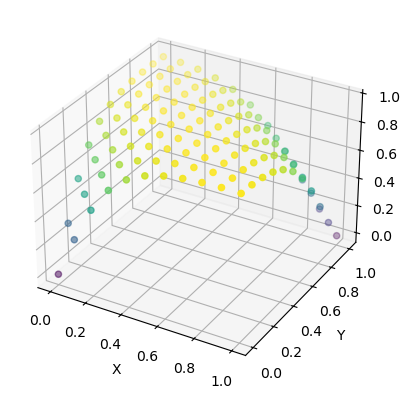

In [24]:
# for creating a responsive plot 
#%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import ipympl
# creating 3d plot using matplotlib  
# in python 
  
  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y from xy_coordinates and use z_outputs as z
x_vals = xor_in[:, 0, 0]
y_vals = xor_in[:, 1, 0]
z_vals = z_outputs[:, 0]

ax.scatter(x_vals, y_vals, z_vals, c=z_vals, cmap='viridis')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()